In [ ]:
#import kagglehub

#path = kagglehub.dataset_download("balraj98/indoor-training-set-its-residestandard")

#print("Path to dataset files:", path)

In [ ]:
#pip install pytorch-ssim

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import vgg16
import pytorch_ssim
from torch import nn, optim
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from google.colab import drive
import random

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available! Using GPU.


In [ ]:
class RESIDEDataset(Dataset):
    def __init__(self, hazy_dir, clear_dir, transform=None):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
        self.hazy_images = sorted(os.listdir(hazy_dir))
        self.clear_ext = ".png"

    def __len__(self):
        return len(self.hazy_images)

    def __getitem__(self, idx):
        hazy_name = self.hazy_images[idx]
        hazy_path = os.path.join(self.hazy_dir, hazy_name)

        base_name = hazy_name.split('_')[0]
        clear_name = base_name + self.clear_ext
        clear_path = os.path.join(self.clear_dir, clear_name)

        hazy = Image.open(hazy_path).convert('RGB')
        clear = Image.open(clear_path).convert('RGB')

        return self.transform(hazy), self.transform(clear)

In [ ]:
dataset = RESIDEDataset(
    hazy_dir='/kaggle/input/indoor-training-set-its-residestandard/hazy',
    clear_dir='/kaggle/input/indoor-training-set-its-residestandard/clear'
)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

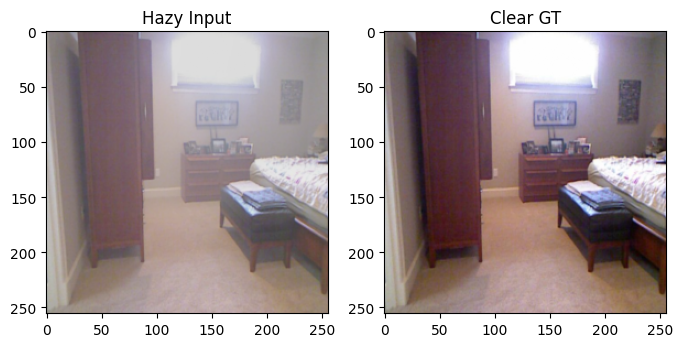

In [ ]:
sample_hazy, sample_clear = dataset[0]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_hazy.permute(1,2,0))
plt.title("Hazy Input")
plt.subplot(1,2,2)
plt.imshow(sample_clear.permute(1,2,0))
plt.title("Clear GT")
plt.show()

# 네트워크

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.ReLU()
    )
  def forward(self, x):
    return self.block(x)

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = ConvBlock(3, 64)

  def forward(self, x):
    return self.encoder(x)

In [ ]:
class DirectDehaze(nn.Module):
  def __init__(self):
    super().__init__()
    self.block = ConvBlock(64, 3)

  def forward(self, feat, input_img):
    return self.block(feat) + input_img

In [ ]:
class CurveAdjustment(nn.Module):
    def __init__(self, num_iter=3):
        super().__init__()
        self.num_iter = num_iter
        self.curves = nn.ModuleList([nn.Conv2d(64, 3, 1) for _ in range(num_iter)])

    def forward(self, feat):
        x = torch.sigmoid(self.curves[0](feat))
        for i in range(1, self.num_iter):
            c = torch.sigmoid(self.curves[i](feat))
            x = x + c * x * (1 - x)
        return x

In [ ]:
class RetinexDecomposition(nn.Module):
    def __init__(self):
        super().__init__()
        self.reflectance = ConvBlock(64, 3)

    def forward(self, feat, input_img):
        R = torch.sigmoid(self.reflectance(feat))
        return input_img * R

In [ ]:
class Fusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, padding=1)
        )

    def forward(self, feat, J_d, J_c, J_r):
        weight = F.softmax(self.fusion_conv(feat), dim=1)
        return (weight[:,0:1]*J_d + weight[:,1:2]*J_c + weight[:,2:3]*J_r)

In [ ]:
class DeepDehazingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.FE = FeatureExtractor()
        self.D_head = DirectDehaze()
        self.C_head = CurveAdjustment()
        self.R_head = RetinexDecomposition()
        self.Fusion = Fusion()

    def forward(self, x):
        feat = self.FE(x)
        J_d = self.D_head(feat, x)
        J_c = self.C_head(feat)
        J_r = self.R_head(feat, x)
        J = self.Fusion(feat, J_d, J_c, J_r)
        return J, J_d, J_c, J_r

# 손실함수

In [ ]:
class DehazingLoss(nn.Module):
    def __init__(self, lambda_1=0.5, lambda_2=1.0, lambda_3=0.5, use_perceptual=True):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3
        self.use_perceptual = use_perceptual

        if use_perceptual:
            vgg = vgg16(pretrained=True).features[:16]
            self.vgg = vgg.eval()
            for p in self.vgg.parameters():
                p.requires_grad = False
            self.vgg.cuda()

    def perceptual(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        return self.l1(x_vgg, y_vgg)

    def forward(self, J, J_d, J_c, J_r, GT):
        loss_basic = self.l1(J_d, GT) + self.l1(J_c, GT) + self.l1(J_r, GT)
        loss_total = self.lambda_1 * loss_basic

        if self.use_perceptual:
            loss_p = self.perceptual(J, GT)
            loss_total += self.lambda_2 * loss_p

        ssim_loss = 1 - pytorch_ssim.ssim(J, GT, window_size=11, size_average=True)
        loss_total += self.lambda_3 * ssim_loss

        return loss_total

#PSNR 함수

In [ ]:
def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [ ]:
def visualize_sample(model, hazy, clear, epoch, save_dir):
    model.eval()
    with torch.no_grad():
        J, _, _, _ = model(hazy.unsqueeze(0).cuda())
        pred = J.squeeze(0).cpu().clamp(0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(hazy.permute(1, 2, 0))
    plt.title("Hazy Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred.permute(1, 2, 0))
    plt.title("Dehazed Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(clear.permute(1, 2, 0))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch}_preview.png"))
    plt.show()

#모델, 옵티마이저, 손실 설정

In [ ]:
model = DeepDehazingNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DehazingLoss(lambda_1=0.5, lambda_2=1.0, lambda_3= 0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 체크포인트 저장 경로 및 하이퍼파라미터

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/dehazing_checkpoints"
result_dir = os.path.join(checkpoint_dir, "results")
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

In [ ]:
num_epochs = 50
save_every = 5

# 학습 루프

🔄 Resumed training from epoch 31


Epoch 31/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [31/50] | Loss: 0.4035 | PSNR: 19.74 | SSIM: 0.8612


Epoch 32/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [32/50] | Loss: 0.4031 | PSNR: 19.75 | SSIM: 0.8616


Epoch 33/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [33/50] | Loss: 0.4028 | PSNR: 19.75 | SSIM: 0.8617


Epoch 34/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [34/50] | Loss: 0.4027 | PSNR: 19.76 | SSIM: 0.8619


Epoch 35/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [35/50] | Loss: 0.4021 | PSNR: 19.77 | SSIM: 0.8623
✅ Checkpoint saved at /content/drive/MyDrive/dehazing_checkpoints/epoch_35.pt


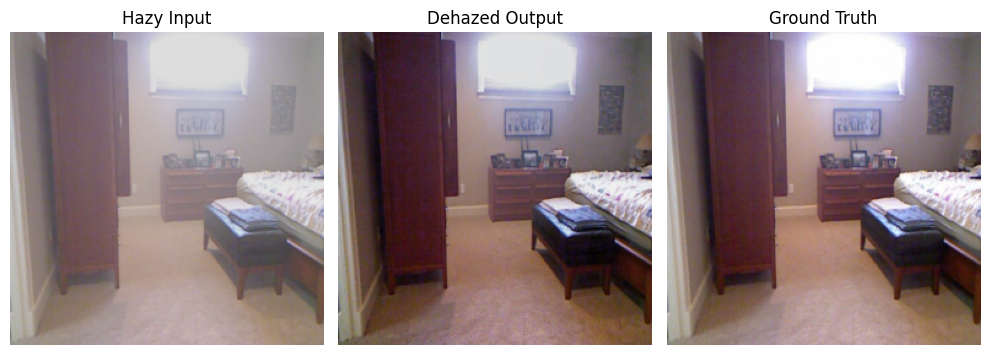

Epoch 36/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [36/50] | Loss: 0.4019 | PSNR: 19.77 | SSIM: 0.8624


Epoch 37/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [37/50] | Loss: 0.4018 | PSNR: 19.77 | SSIM: 0.8625


Epoch 38/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [38/50] | Loss: 0.4016 | PSNR: 19.77 | SSIM: 0.8628


Epoch 39/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [39/50] | Loss: 0.4013 | PSNR: 19.78 | SSIM: 0.8629


Epoch 40/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [40/50] | Loss: 0.4009 | PSNR: 19.79 | SSIM: 0.8633
✅ Checkpoint saved at /content/drive/MyDrive/dehazing_checkpoints/epoch_40.pt


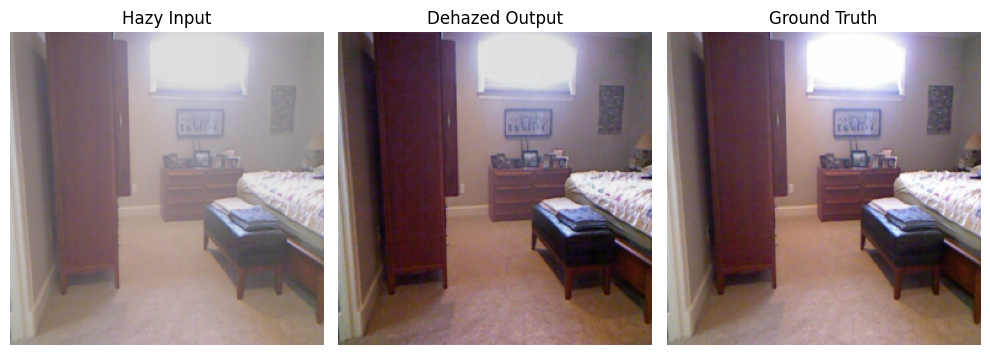

Epoch 41/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [41/50] | Loss: 0.4007 | PSNR: 19.79 | SSIM: 0.8633


Epoch 42/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [42/50] | Loss: 0.4004 | PSNR: 19.80 | SSIM: 0.8635


Epoch 43/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [43/50] | Loss: 0.4001 | PSNR: 19.80 | SSIM: 0.8638


Epoch 44/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [44/50] | Loss: 0.4002 | PSNR: 19.79 | SSIM: 0.8638


Epoch 45/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [45/50] | Loss: 0.4001 | PSNR: 19.80 | SSIM: 0.8639
✅ Checkpoint saved at /content/drive/MyDrive/dehazing_checkpoints/epoch_45.pt


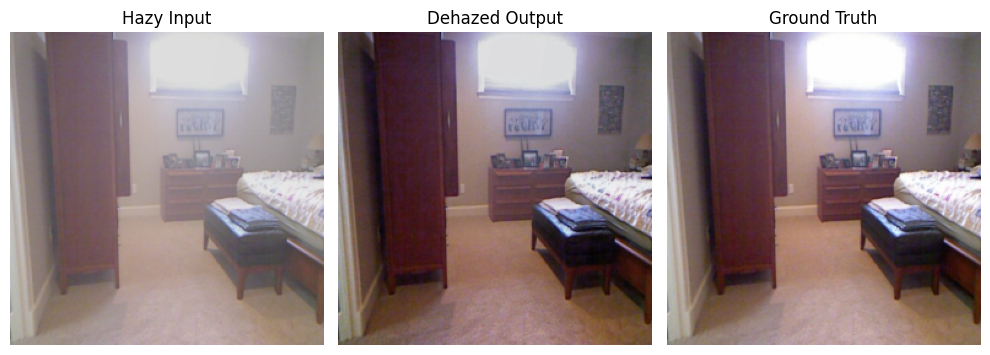

Epoch 46/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [46/50] | Loss: 0.3996 | PSNR: 19.82 | SSIM: 0.8643


Epoch 47/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [47/50] | Loss: 0.3997 | PSNR: 19.81 | SSIM: 0.8642


Epoch 48/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [48/50] | Loss: 0.3993 | PSNR: 19.82 | SSIM: 0.8646


Epoch 49/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [49/50] | Loss: 0.3994 | PSNR: 19.81 | SSIM: 0.8645


Epoch 50/50:   0%|          | 0/1749 [00:00<?, ?it/s]


📌 Epoch [50/50] | Loss: 0.3989 | PSNR: 19.82 | SSIM: 0.8649
✅ Checkpoint saved at /content/drive/MyDrive/dehazing_checkpoints/epoch_50.pt


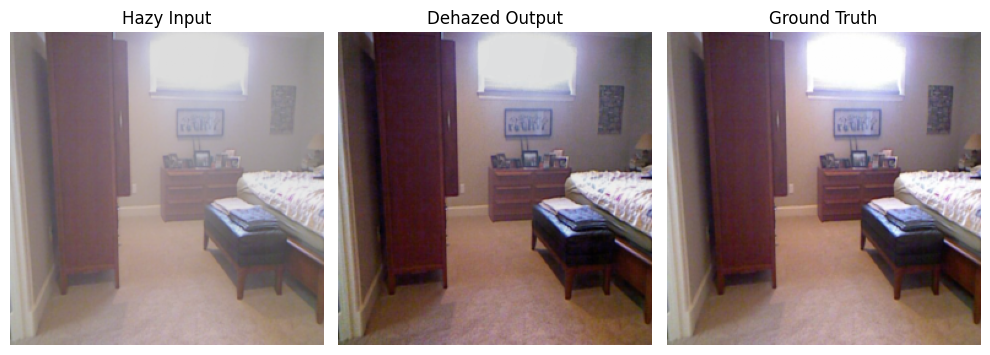

In [ ]:
resume_training = True
checkpoint_path = '/content/drive/MyDrive/dehazing_checkpoints/epoch_30.pt'
start_epoch = 1

if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔄 Resumed training from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    total_loss, total_psnr, total_ssim = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    for hazy, clear in pbar:
        hazy, clear = hazy.cuda(), clear.cuda()
        J, J_d, J_c, J_r = model(hazy)

        loss = criterion(J, J_d, J_c, J_r, clear)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            batch_psnr = sum(compute_psnr(J[i], clear[i]) for i in range(J.size(0)))
            batch_ssim = sum(pytorch_ssim.ssim(J[i].unsqueeze(0), clear[i].unsqueeze(0)).item()
                             for i in range(J.size(0)))

        total_loss += loss.item()
        total_psnr += batch_psnr
        total_ssim += batch_ssim
        pbar.set_postfix({"Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    avg_psnr = total_psnr / (len(train_loader.dataset))
    avg_ssim = total_ssim / (len(train_loader.dataset))

    print(f"\n📌 Epoch [{epoch}/{num_epochs}] | Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

    if epoch % save_every == 0:
        ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
        }, ckpt_path)
        print(f"✅ Checkpoint saved at {ckpt_path}")

    if epoch % save_every == 0:
        hazy_sample, clear_sample = dataset[0]
        visualize_sample(model, hazy_sample, clear_sample, epoch, result_dir)

# 예측 결과 저장 및 시각화

In [ ]:
ckpt_path = "/content/drive/MyDrive/dehazing_checkpoints/epoch_50.pt"
checkpoint = torch.load(ckpt_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

In [ ]:
def visualize_with_ckpt(model, dataset, save_dir, ckpt_path, num_samples=5):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.cuda()
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            hazy, clear = dataset[idx]
            hazy_batch = hazy.unsqueeze(0).cuda()

            J, _, _, _ = model(hazy_batch)
            J = J.squeeze(0).cpu()
            clear = clear.cpu()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(hazy.permute(1, 2, 0).clamp(0, 1))
            plt.title("Hazy Input")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(J.permute(1, 2, 0).clamp(0, 1))
            plt.title("Dehazed Output")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(clear.permute(1, 2, 0).clamp(0, 1))
            plt.title("Ground Truth")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

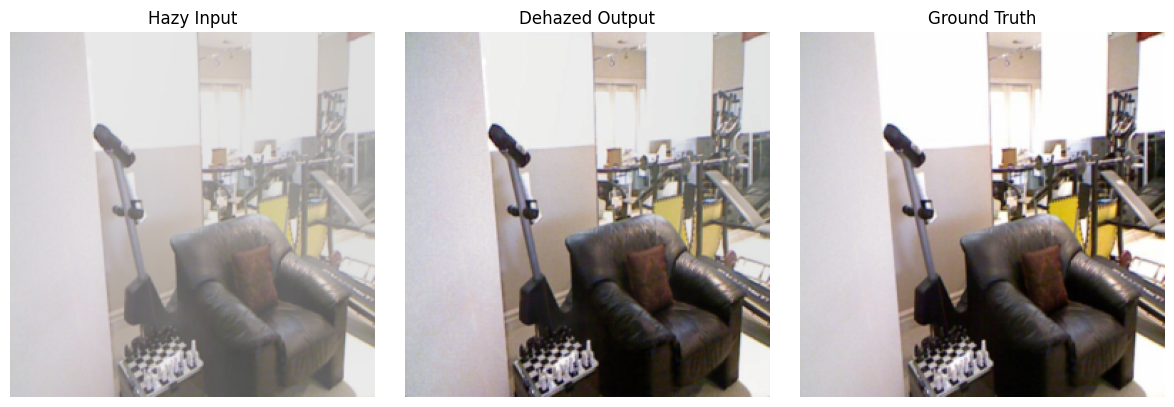

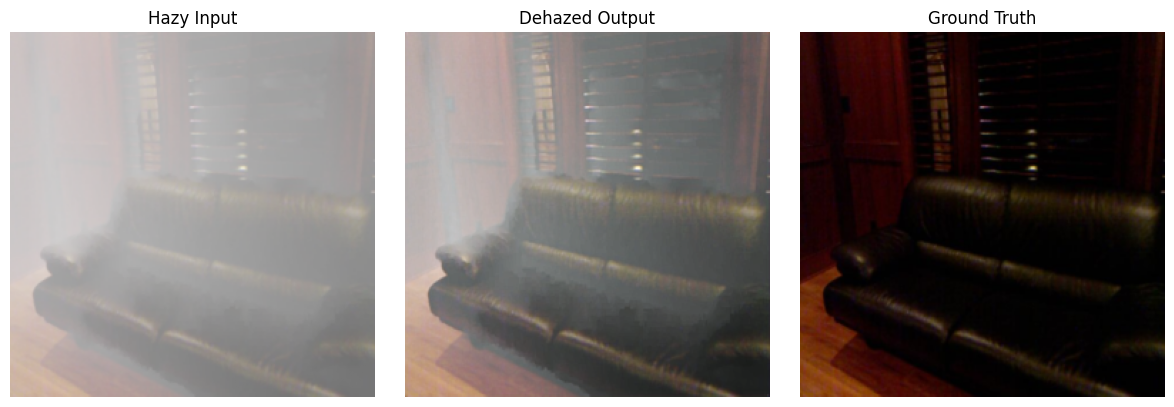

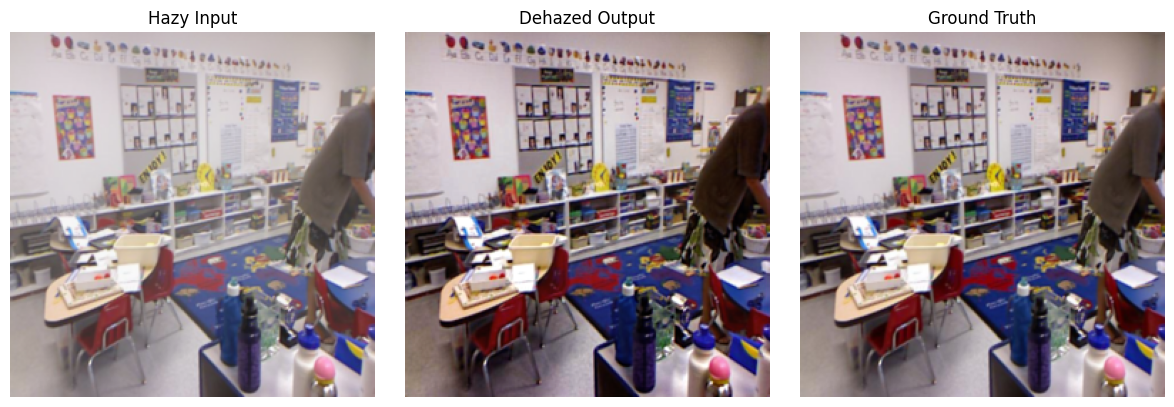

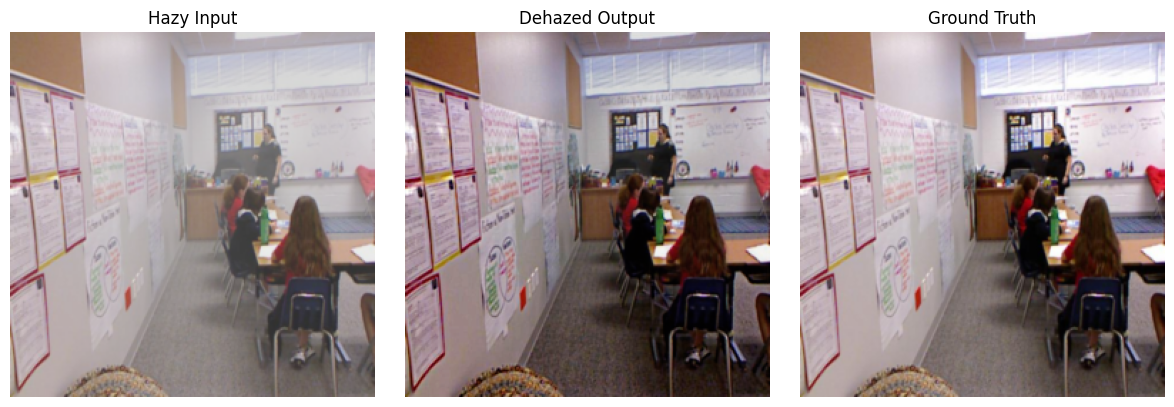

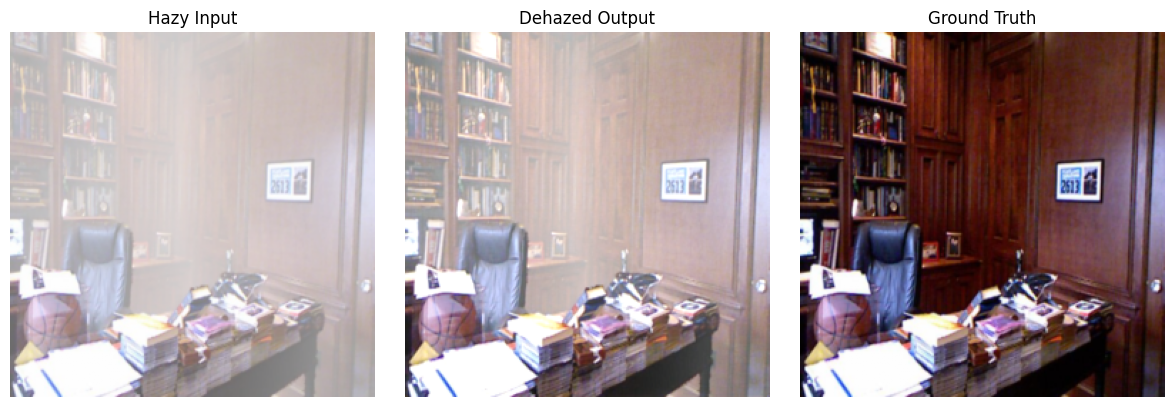

In [ ]:
visualize_with_ckpt(model, dataset, save_dir="/content/drive/MyDrive/dehazing_results", ckpt_path=ckpt_path, num_samples=5)

# 테스트 코드

In [ ]:
def test_model(model, dataloader):
    model.eval()
    total_psnr, total_ssim = 0.0, 0.0
    num_images = 0

    with torch.no_grad():
        for hazy, clear in dataloader:
            hazy, clear = hazy.cuda(), clear.cuda()
            J, _, _, _ = model(hazy)

            for i in range(hazy.size(0)):
                pred = J[i].clamp(0, 1)
                gt = clear[i]

                psnr = compute_psnr(pred, gt)
                ssim = pytorch_ssim.ssim(pred.unsqueeze(0), gt.unsqueeze(0))
                total_psnr += psnr
                total_ssim += ssim.item()
                num_images += 1

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images
    print(f"📊 PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

In [ ]:
test_model(model, train_loader)

📊 PSNR: 19.88, SSIM: 0.8660


(19.878333852937, 0.8660256125432325)